Applying effects, filters, RIR ( room impulse response ) and codecs.

In [1]:
import torch
import torchaudio
import torchaudio.functional as F

import math
from IPython.display import Audio
import matplotlib.pyplot as plt

from torchaudio.utils import download_asset

In [2]:
SAMPLE_WAV = download_asset("tutorial-assets/steam-train-whistle-daniel_simon.wav")
SAMPLE_RIR = download_asset("tutorial-assets/Lab41-SRI-VOiCES-rm1-impulse-mc01-stu-clo-8000hz.wav")
SAMPLE_SPEECH = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042-8000hz.wav")
SAMPLE_NOISE = download_asset("tutorial-assets/Lab41-SRI-VOiCES-rm1-babb-mc01-stu-clo-8000hz.wav")

100.0%
100.0%
100.0%


torchaudio.sox_effects() : directly apply filters similar to thos available in sox to tensor objects.

torchaudio.sox_effects.apply_effects_tensor() applying effects to Tensor
torchaudio.sox_effects.apply_effects_file() applying effects to other audio sources.

resample your audio data on the fly with torchaudio.sox_effects_file() with effect "rate".

In [5]:
# Load the data
waveform1, sample_rate1 = torchaudio.load(SAMPLE_WAV)

# Define effects

effects = [
    ['lowpass', '-1','300'], # apply single-pole lowpale lowpasss filter
    ['speed', '0.8'], # reduce the speed
    # This only changes sample rate, so it is necessary to 
    # add 'rate' effect with original sample rate after this.
    ['rate', f"{sample_rate1}"],
    ['reverb', '-w'], # Reverbration gives some dramatic feeling
]

# Apply effects 
waveform2, sample_rate2 = torchaudio.sox_effects.apply_effects_tensor(waveform1, sample_rate1, effects)

In [7]:
print(waveform1.shape, sample_rate1)
print(waveform2.shape, sample_rate2)

torch.Size([2, 109368]) 44100
torch.Size([2, 136710]) 44100


In [8]:
def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
    figure.suptitle(title)
    plt.show(block=False)


In [9]:
def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
    waveform = waveform.numpy()

    num_channels, _ = waveform.shape

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
    figure.suptitle(title)
    plt.show(block=False)

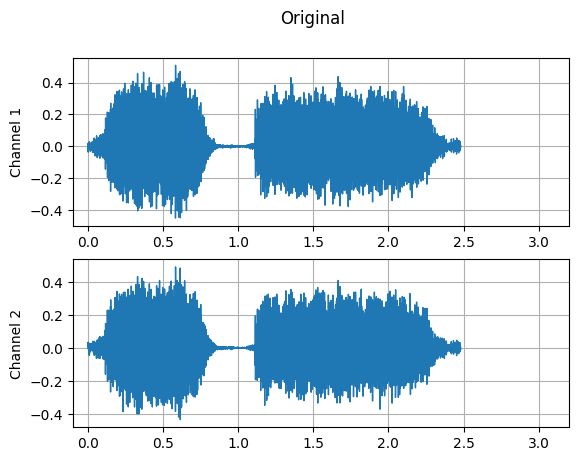

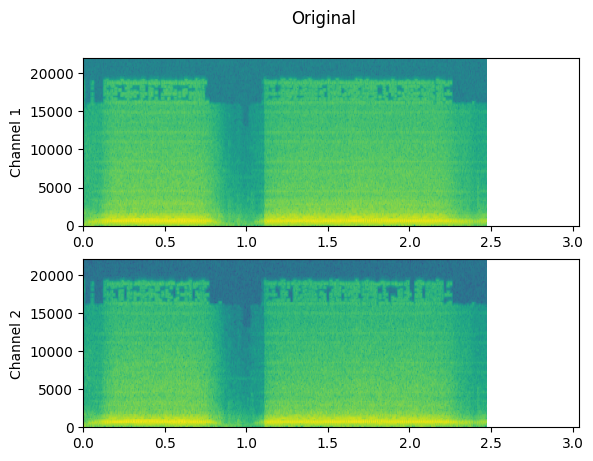

In [10]:
plot_waveform(waveform1, sample_rate1, title="Original", xlim=(-0.1, 3.2))
plot_specgram(waveform1, sample_rate1, title="Original", xlim=(0, 3.04))
Audio(waveform1, rate=sample_rate1)

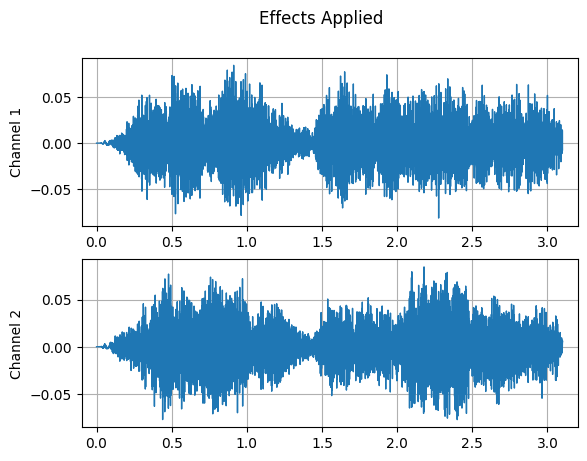

/Users/amani/Desktop/pytorch_directory/untitled_folder/new_dir/lib/python3.9/site-packages/matplotlib/axes/_axes.py:7720: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


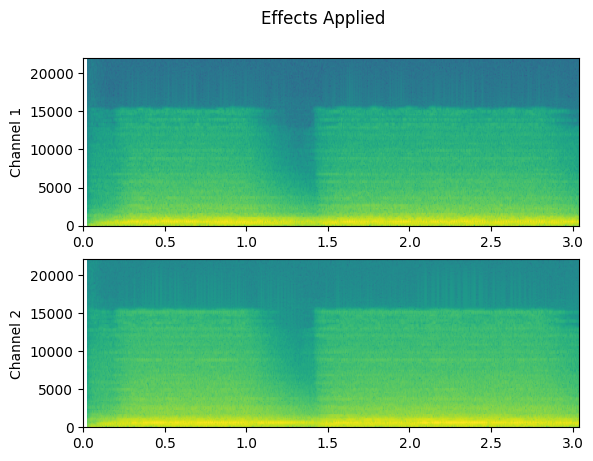

In [11]:
plot_waveform(waveform2, sample_rate2, title="Effects Applied", xlim=(-0.1, 3.2))
plot_specgram(waveform2, sample_rate2, title="Effects Applied", xlim=(0, 3.04))
Audio(waveform2, rate=sample_rate2)

simulating room reverberation - 

convolution reverb used to make clean audio sound as though it was producted in a different environment.
RIR ( Room Impluse Response ) -> turn clean speech sound -> uttered in a conference room.

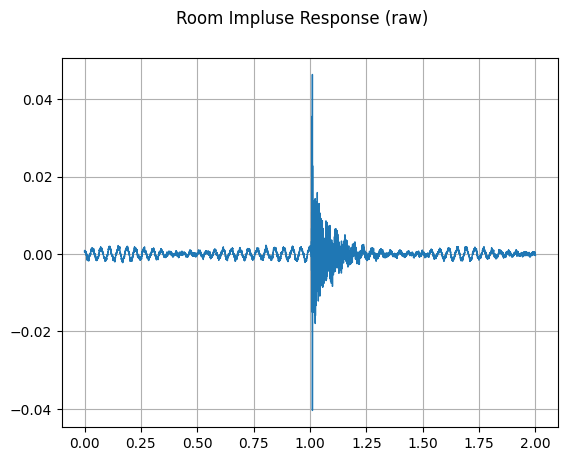

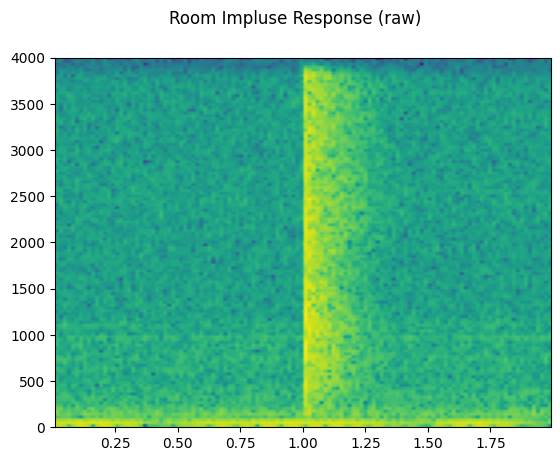

In [12]:
rir_raw, sample_rate = torchaudio.load(SAMPLE_RIR)
plot_waveform(rir_raw, sample_rate, title="Room Impluse Response (raw)")
plot_specgram(rir_raw, sample_rate, title="Room Impluse Response (raw)")
Audio(rir_raw, rate=sample_rate)

# RIR ( ROOM IMPULSE RESPONSE )

what is the RIR ?

The room impulse response is the transfer function between the sound source and microphone. In order to recover the original sound source, the received microphone signal can be convolved with the inverse of the room impulse response function.

clean up the RIR. extract the main impluse -> then normalize the signal power -> then flip along the time axis.

In [14]:
# extract the main impulse.
rir = rir_raw[:, int(sample_rate * 1.01) : int(sample_rate * 1.3)]

# normalize the signal power.
rir = rir / torch.norm(rir, p=2)

# flip along the time axis.
RIR = torch.flip(rir, [1])

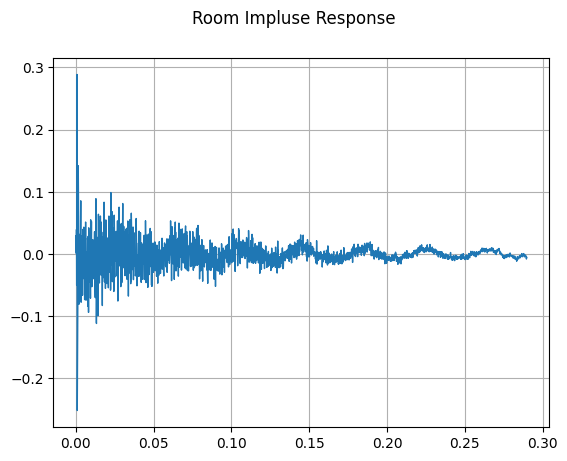

In [15]:
plot_waveform(rir, sample_rate, title="Room Impluse Response")


In [16]:
speech, _ =torchaudio.load(SAMPLE_SPEECH)

speech_ = torch.nn.functional.pad(speech, (RIR.shape[1] - 1, 0))
augmented = torch.nn.functional.conv1d(speech_[None, ...], RIR[None, ...])[0]

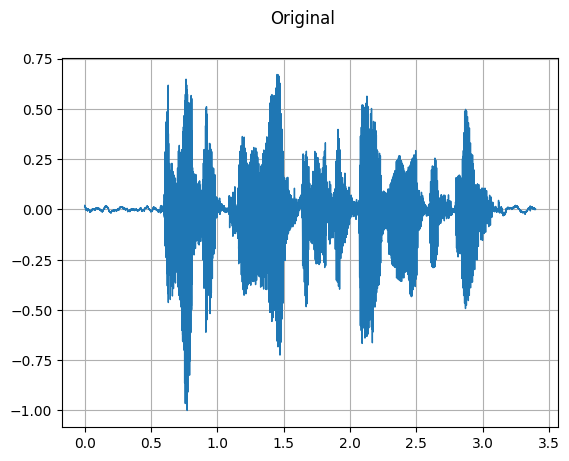

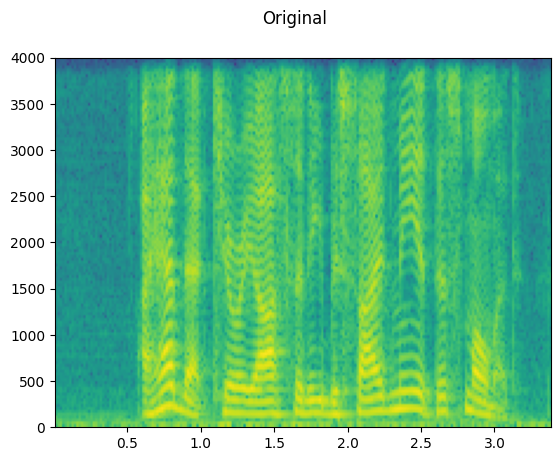

In [17]:
plot_waveform(speech, sample_rate, title="Original")
plot_specgram(speech, sample_rate, title="Original")
Audio(speech, rate=sample_rate)

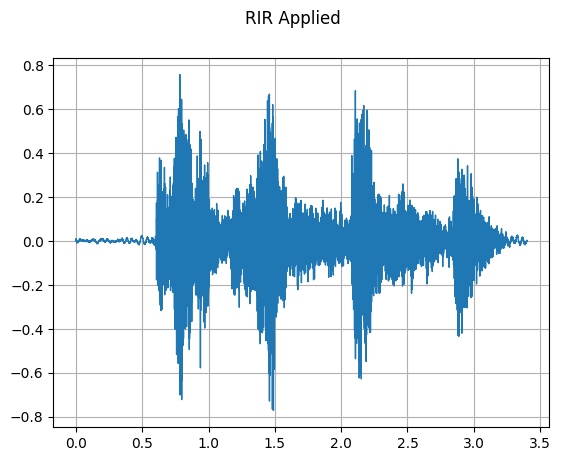

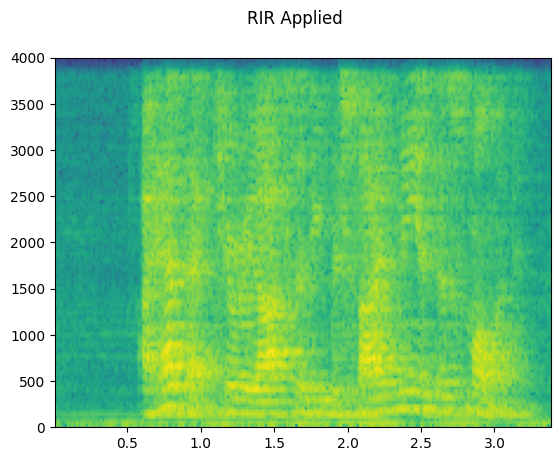

In [18]:
plot_waveform(augmented, sample_rate, title="RIR Applied")
plot_specgram(augmented, sample_rate, title="RIR Applied")
Audio(augmented, rate=sample_rate)

# Signal to Noise Ratio

Add a noise Tensor to the Tensor representing the audio data.

Adjust intensity of noise by changing Signal-to-Noise Ratio (SNR)

$$ \mathrm{SNR} = \frac{P_{signal}}{P_{noise}} $$

$$ \mathrm{SNR_{dB}} = 10 \log _{{10}} \mathrm {SNR} $$

In [19]:
speech, _ = torchaudio.load(SAMPLE_SPEECH)
noise, _ = torchaudio.load(SAMPLE_NOISE)
noise = noise[:, : speech.shape[1]]

speech_rms = speech.norm(p=2)
noise_rms = noise.norm(p=2)

snr_dbs = [20, 10, 3]
noisy_speeches = []
for snr_db in snr_dbs:
    snr = 10 ** (snr_db / 20)
    scale = snr * noise_rms / speech_rms
    noisy_speeches.append((scale * speech + noise) / 2)

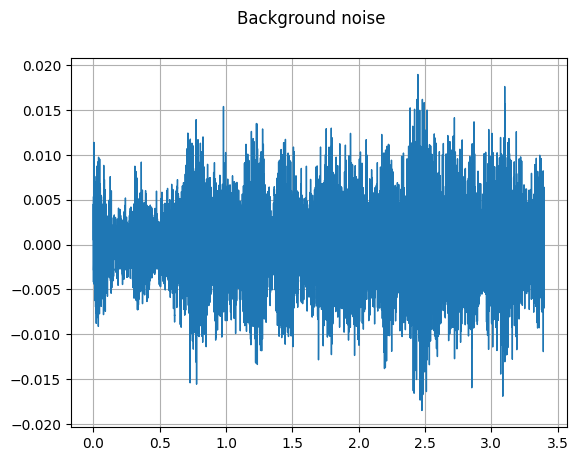

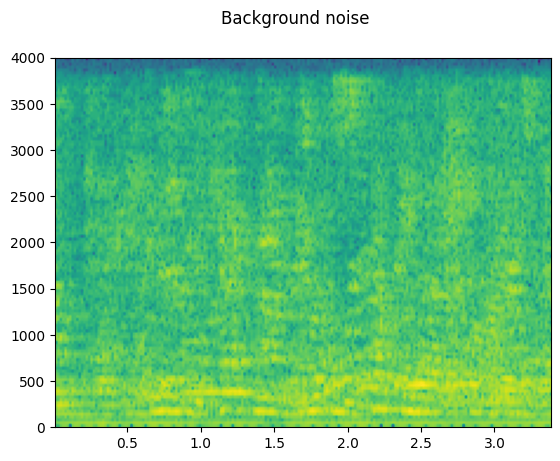

In [20]:
plot_waveform(noise, sample_rate, title="Background noise")
plot_specgram(noise, sample_rate, title="Background noise")
Audio(noise, rate=sample_rate)

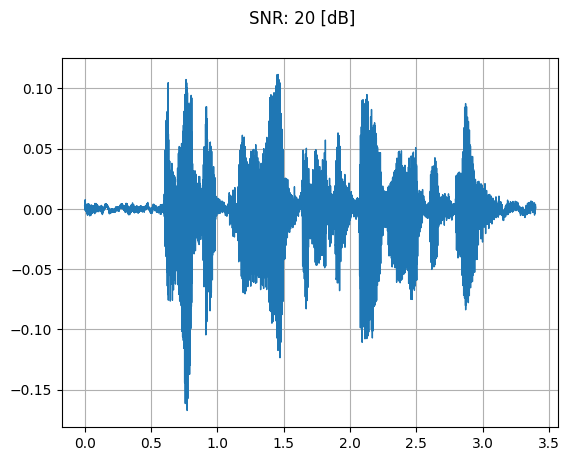

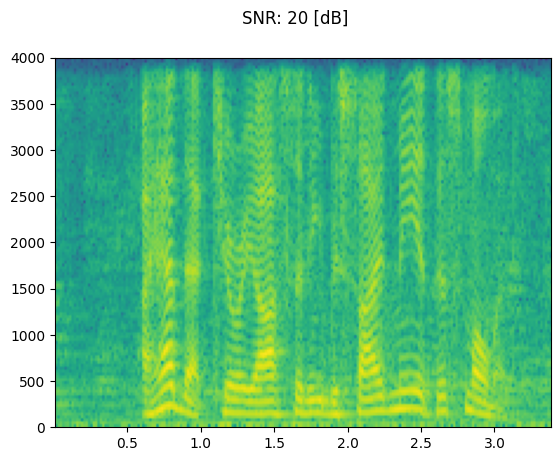

In [21]:
snr_db, noisy_speech = snr_dbs[0], noisy_speeches[0]
plot_waveform(noisy_speech, sample_rate, title=f"SNR: {snr_db} [dB]")
plot_specgram(noisy_speech, sample_rate, title=f"SNR: {snr_db} [dB]")
Audio(noisy_speech, rate=sample_rate)

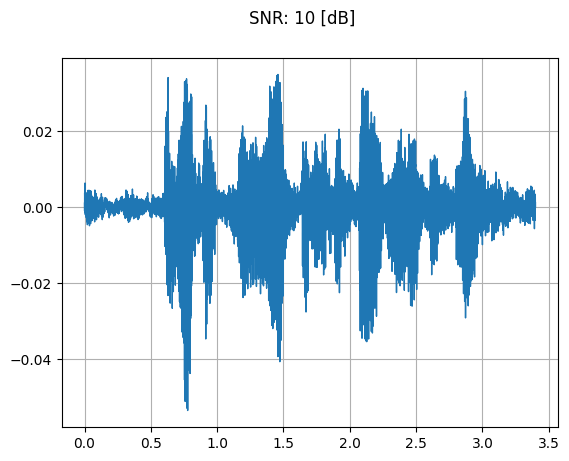

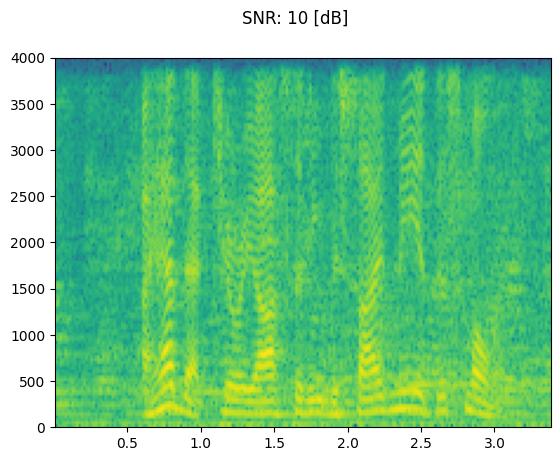

In [22]:
snr_db, noisy_speech = snr_dbs[1], noisy_speeches[1]
plot_waveform(noisy_speech, sample_rate, title=f"SNR: {snr_db} [dB]")
plot_specgram(noisy_speech, sample_rate, title=f"SNR: {snr_db} [dB]")
Audio(noisy_speech, rate=sample_rate)

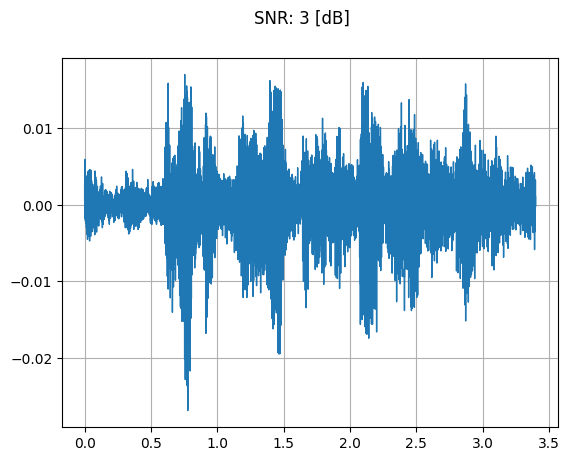

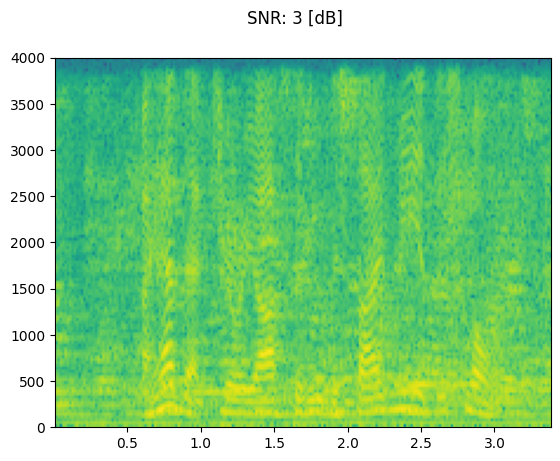

In [23]:
snr_db, noisy_speech = snr_dbs[2], noisy_speeches[2]
plot_waveform(noisy_speech, sample_rate, title=f"SNR: {snr_db} [dB]")
plot_specgram(noisy_speech, sample_rate, title=f"SNR: {snr_db} [dB]")
Audio(noisy_speech, rate=sample_rate)

# APPLYING CODEC TO TENSOR OBJECT

torchaudio.functional.appy_codec() can apply codecs to a Tensor object.

In [24]:
waveform, sample_rate = torchaudio.load(SAMPLE_SPEECH)

configs = [
    {"format": "wav", "encoding": "ULAW", "bits_per_sample": 8},
    {"format": "gsm"},
    {"format": "vorbis", "compression": -1},
]
waveforms = []
for param in configs:
    augmented = F.apply_codec(waveform, sample_rate, **param)
    waveforms.append(augmented)

formats: gsm can't encode GSM to 16-bit
formats: vorbis can't encode Vorbis to 16-bit


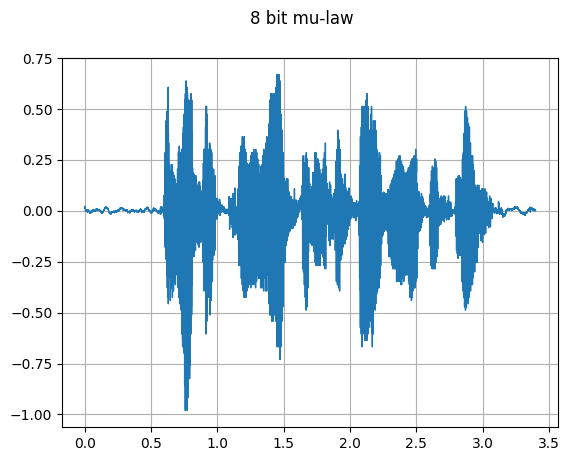

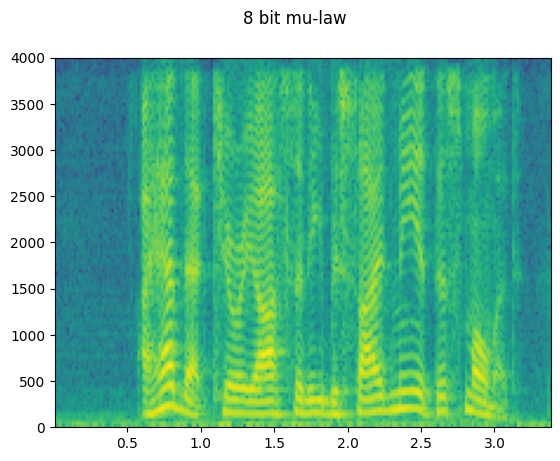

In [25]:
plot_waveform(waveforms[0], sample_rate, title="8 bit mu-law")
plot_specgram(waveforms[0], sample_rate, title="8 bit mu-law")
Audio(waveforms[0], rate=sample_rate)

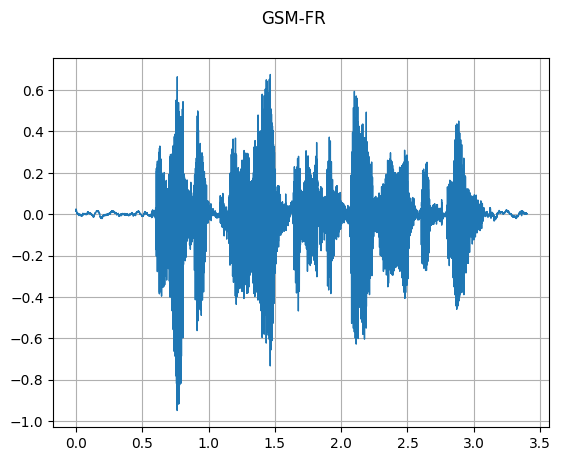

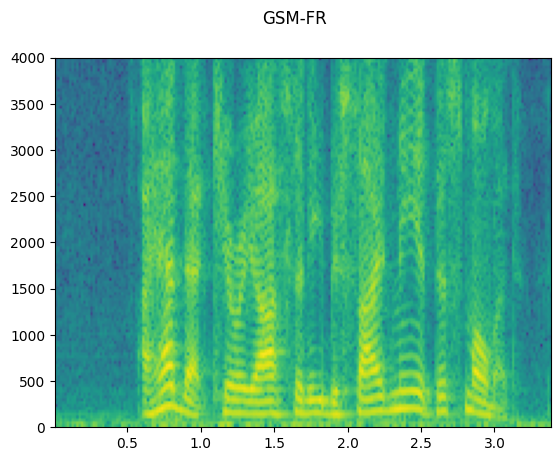

In [26]:
plot_waveform(waveforms[1], sample_rate, title="GSM-FR")
plot_specgram(waveforms[1], sample_rate, title="GSM-FR")
Audio(waveforms[1], rate=sample_rate)

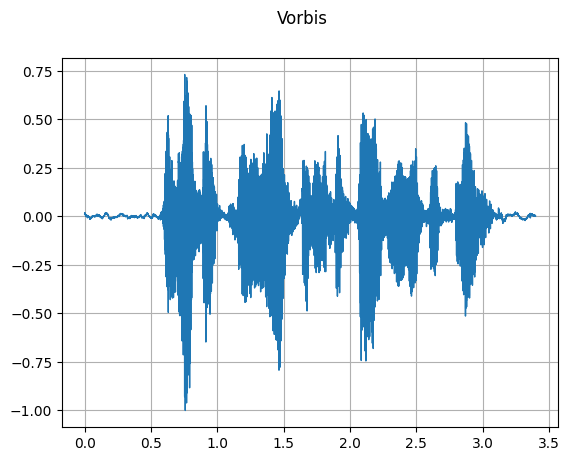

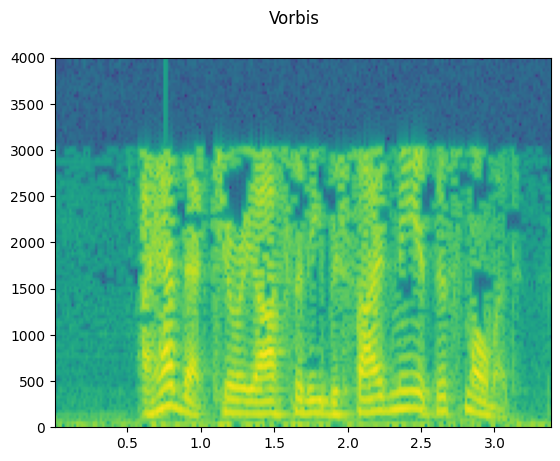

In [27]:
plot_waveform(waveforms[2], sample_rate, title="Vorbis")
plot_specgram(waveforms[2], sample_rate, title="Vorbis")
Audio(waveforms[2], rate=sample_rate)